In [1]:
#!pip install tensorflow

In [2]:
#!pip install -q tensorflow-hub

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

import numpy as np
import PIL.Image as Image
import os


import matplotlib.pylab as plt

In [4]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [5]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 

In [6]:
IMAGE_SHAPE = (224,224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [107]:
checkpoint_folder = "D://Users//rdemaio//Documents//Progetti//ImagePicker//checkpoints"
PATH = "C://Users//rdemaio//Desktop//immagini"

In [37]:

train_dir = os.path.join(PATH,'train')
validation_dir = os.path.join(PATH,'test')

train_good_dir = os.path.join(train_dir, 'Good')
train_bad_dir = os.path.join(train_dir, 'Bad')
validation_good_dir = os.path.join(validation_dir, 'Good')
validation_bad_dir = os.path.join(validation_dir, 'Bad')

num_good_tr = len(os.listdir(train_good_dir))
num_bad_tr = len(os.listdir(train_bad_dir))

num_good_val = len(os.listdir(validation_good_dir))
num_bad_val = len(os.listdir(validation_bad_dir))

total_train = num_good_tr + num_bad_tr
total_val = num_good_val + num_bad_val
print('total training good images:', num_good_tr,"(",100*num_good_tr/total_train,"%)" )
print('total training bad images:', num_bad_tr,"(",100*num_bad_tr/total_train,"%)")
print('total validation good images:', num_good_val,"(",100*num_good_val/total_val,"%)")
print('total validation bad images:', num_bad_val,"(",100*num_good_val/total_val,"%)")
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training good images: 93 ( 40.61135371179039 %)
total training bad images: 136 ( 59.38864628820961 %)
total validation good images: 12 ( 35.294117647058826 %)
total validation bad images: 22 ( 35.294117647058826 %)
--
Total training images: 229
Total validation images: 34


In [42]:
# Controlliamo se ci sono duplicati nelle cartelle ed in caso andremo a rimuoverli manualmente
x = [f for f in os.listdir(train_good_dir)]+[f for f in os.listdir(train_bad_dir)]+[f for f in os.listdir(validation_good_dir)]+ [f for f in os.listdir(validation_bad_dir)]
from collections import Counter
c= Counter(x)
for key,value in c.items():
    if value > 1:
        print("File ",key)
        print("It is in:")
        if key in [f for f in os.listdir(train_good_dir)]:
            print(os.path.join(train_good_dir, key))
        if key in [f for f in os.listdir(train_bad_dir)]:
            print(os.path.join(train_bad_dir, key))
        if key in [f for f in os.listdir(validation_good_dir)]:
            print(os.path.join(validation_good_dir, key))
        if key in [f for f in os.listdir(validation_bad_dir)]:
            print(os.path.join(validation_bad_dir, key))

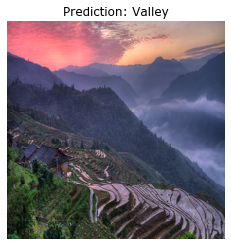

In [43]:
from random import choice
file  = choice([f for f in os.listdir(train_good_dir)])
im = Image.open(os.path.join(train_good_dir, file)).resize(IMAGE_SHAPE)
#im
im = np.array(im)/255.0
#im.shape
result = classifier.predict(im[np.newaxis, ...])
#result.shape
predicted_class = np.argmax(result[0], axis=-1)
#predicted_class
plt.imshow(im)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [44]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.0, 
    horizontal_flip=True,
    rotation_range=0,
    width_shift_range = .0,
    height_shift_range = .0,
    shear_range = 0.0,
    zoom_range = 0.1,
    fill_mode = "nearest"
)
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.0, 
    horizontal_flip=True,
    rotation_range=0,
    width_shift_range = .0,
    height_shift_range = .0,
    shear_range = 0.0,
    zoom_range = 0.1,
    fill_mode = "nearest"
)

In [77]:
batch_size = 15
epochs = 10

In [78]:
train_data_gen = train_image_generator.flow_from_directory(batch_size = batch_size, 
                                                           directory = train_dir, 
                                                           shuffle = True,
                                                           target_size = IMAGE_SHAPE,
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size = batch_size, 
                                                           directory = validation_dir, 
                                                           shuffle = True,
                                                           target_size = IMAGE_SHAPE,
                                                           class_mode='binary')

Found 229 images belonging to 2 classes.
Found 34 images belonging to 2 classes.


In [79]:
sample_train_images, _ = next(train_data_gen)
#sample_train_images.shape

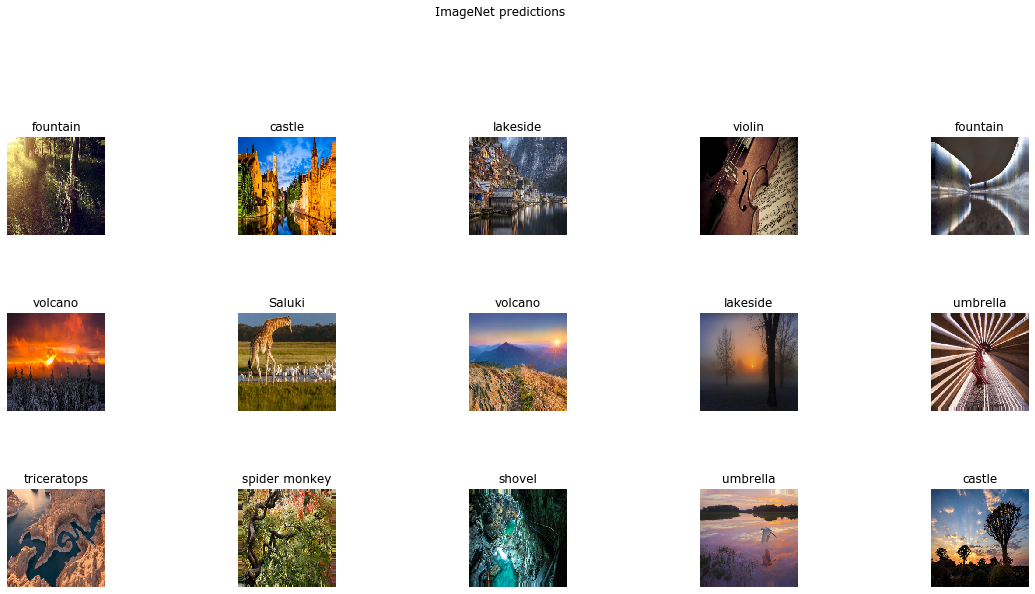

In [80]:
result_batch = classifier.predict(sample_train_images)
#result_batch.shape
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
#predicted_class_names
plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.8)
for n in range(batch_size):
    plt.subplot(6,5,n+1)
    plt.imshow(sample_train_images[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

In [81]:
classifier.trainable=False

In [82]:
model = tf.keras.Sequential([
  classifier,
  layers.Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1001)              3540265   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1002      
Total params: 3,541,267
Trainable params: 1,002
Non-trainable params: 3,540,265
_________________________________________________________________


In [83]:
#predictions = model(sample_train_images)
#predictions.shape

In [84]:
opt = tf.keras.optimizers.Adam(
    learning_rate = 0.0007
)
model.compile(optimizer = opt,
             loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
             metrics=['accuracy','AUC','Precision'])

In [85]:
history = model.fit(
    train_data_gen,
    steps_per_epoch = int(total_train/batch_size),
    epochs = epochs,
    validation_data = val_data_gen,
    validation_steps = int(total_val/batch_size)#,
    #batch_stats_callback = CollectBatchStats()
)

Epoch 1/10
15/15 [==============================] - 21s 1s/step - loss: 0.8421 - accuracy: 0.5748 - auc: 0.5727 - precision: 0.4894 - val_loss: 0.7640 - val_accuracy: 0.6000 - val_auc: 0.6296 - val_precision: 0.5000
Epoch 2/10
15/15 [==============================] - 19s 1s/step - loss: 0.7422 - accuracy: 0.6402 - auc: 0.6392 - precision: 0.5618 - val_loss: 0.6551 - val_accuracy: 0.5667 - val_auc: 0.6986 - val_precision: 0.4375
Epoch 3/10
15/15 [==============================] - 18s 1s/step - loss: 0.6639 - accuracy: 0.6682 - auc: 0.7028 - precision: 0.5882 - val_loss: 0.5904 - val_accuracy: 0.7333 - val_auc: 0.7275 - val_precision: 0.5455
Epoch 4/10
15/15 [==============================] - 21s 1s/step - loss: 0.6055 - accuracy: 0.6776 - auc: 0.7396 - precision: 0.6173 - val_loss: 0.5539 - val_accuracy: 0.6333 - val_auc: 0.7464 - val_precision: 0.5000
Epoch 5/10
15/15 [==============================] - 18s 1s/step - loss: 0.5714 - accuracy: 0.7290 - auc: 0.7636 - precision: 0.6707 - va

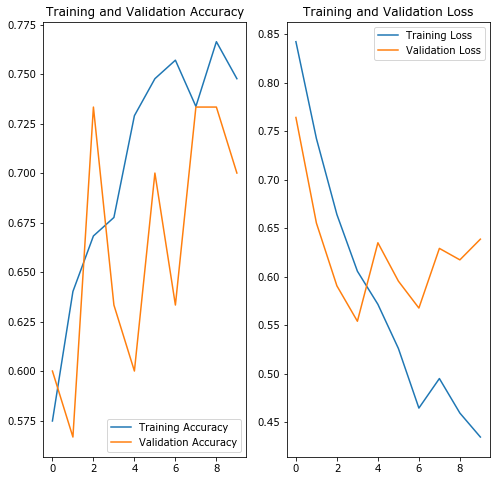

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

D:\Users\rdemaio\Anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


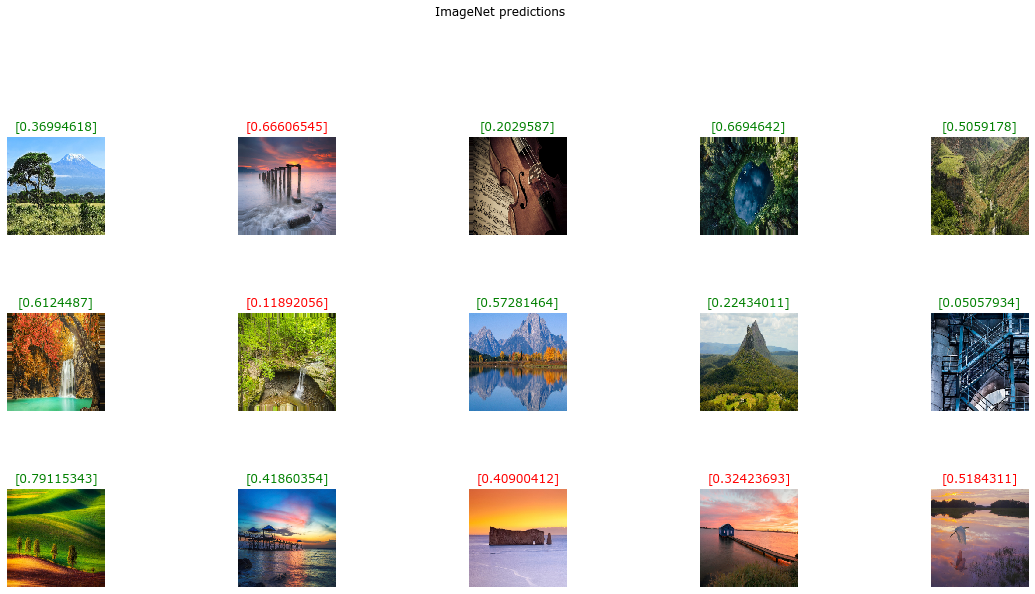

In [89]:
THRESHOLD = 0.5

sample_train_images, sample_label_images = next(train_data_gen)
result_batch = model.predict(sample_train_images)
result_batch
plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.8)
for n in range(batch_size):
    plt.subplot(6,5,n+1)
    plt.imshow(sample_train_images[n])
    color = "green" if ((result_batch[n]>=THRESHOLD)&(sample_label_images[n]==1.0))|((result_batch[n]<THRESHOLD)&(sample_label_images[n]==0.0)) else "red"
    plt.title(result_batch[n], color = color)
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

In [90]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

In [91]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3),
                                        trainable=False)

In [92]:
model_2 = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(1,activation = 'sigmoid')
])

model_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [97]:
opt = tf.keras.optimizers.Adam(
    learning_rate = 0.001
)
model_2.compile(optimizer = opt,
             loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
             metrics=['accuracy','AUC'])

In [98]:
history = model_2.fit(
    train_data_gen,
    steps_per_epoch = int(total_train/batch_size),
    epochs = epochs,
    validation_data = val_data_gen,
    validation_steps = int(total_val/batch_size)#,
    #batch_stats_callback = CollectBatchStats()
)

Epoch 1/10
15/15 [==============================] - 24s 2s/step - loss: 0.6682 - accuracy: 0.6308 - auc: 0.6367 - val_loss: 0.5430 - val_accuracy: 0.7667 - val_auc: 0.8075
Epoch 2/10
15/15 [==============================] - 34s 2s/step - loss: 0.6147 - accuracy: 0.6869 - auc: 0.7197 - val_loss: 0.5443 - val_accuracy: 0.6333 - val_auc: 0.7536
Epoch 3/10
15/15 [==============================] - 30s 2s/step - loss: 0.5667 - accuracy: 0.6776 - auc: 0.7549 - val_loss: 0.4997 - val_accuracy: 0.8000 - val_auc: 0.8150
Epoch 4/10
15/15 [==============================] - 16s 1s/step - loss: 0.5302 - accuracy: 0.7009 - auc: 0.7921 - val_loss: 0.5019 - val_accuracy: 0.7667 - val_auc: 0.7895
Epoch 5/10
15/15 [==============================] - 21s 1s/step - loss: 0.4907 - accuracy: 0.7617 - auc: 0.8435 - val_loss: 0.5286 - val_accuracy: 0.7000 - val_auc: 0.7488
Epoch 6/10
15/15 [==============================] - 19s 1s/step - loss: 0.4646 - accuracy: 0.7804 - auc: 0.8706 - val_loss: 0.5009 - val_acc

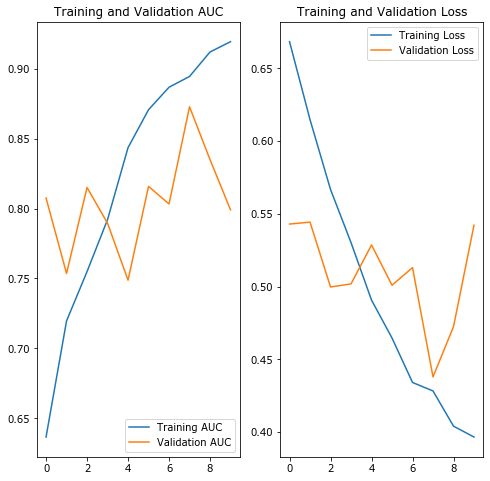

In [101]:
acc = history.history['auc']
val_acc = history.history['val_auc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training AUC')
plt.plot(epochs_range, val_acc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

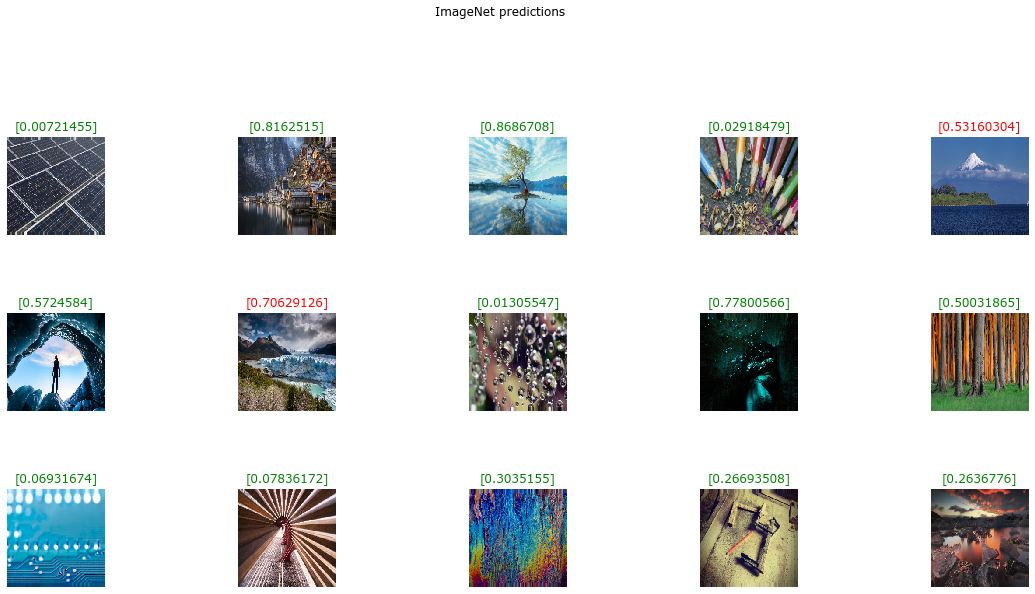

In [106]:
THRESHOLD = 0.5

sample_train_images, sample_label_images = next(train_data_gen)
result_batch = model_2.predict(sample_train_images)
result_batch
plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.8)
for n in range(batch_size):
    plt.subplot(6,5,n+1)
    plt.imshow(sample_train_images[n])
    color = "green" if ((result_batch[n]>=THRESHOLD)&(sample_label_images[n]==1.0))|((result_batch[n]<THRESHOLD)&(sample_label_images[n]==0.0)) else "red"
    plt.title(result_batch[n], color = color)
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

In [117]:
#Saved Chosen Model
model_2.save(checkpoint_folder+"//ImagePicker")

INFO:tensorflow:Assets written to: D://Users//rdemaio//Documents//Progetti//ImagePicker//checkpoints//ImagePicker\assets


INFO:tensorflow:Assets written to: D://Users//rdemaio//Documents//Progetti//ImagePicker//checkpoints//ImagePicker\assets


In [119]:
#Check Load method
new_model = tf.keras.models.load_model(checkpoint_folder+"//ImagePicker")

# Check its architecture
new_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              1280      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1281      
Total params: 2,561
Trainable params: 1,281
Non-trainable params: 1,280
_________________________________________________________________


In [128]:
from random import choice
file  = choice([f for f in os.listdir(train_good_dir)])
im = Image.open(os.path.join(train_good_dir, file)).resize(IMAGE_SHAPE)
#im
im = np.array(im)/255.0
#im.shape
result = model_2.predict(im[np.newaxis, ...])
result.shape
#plt.imshow(im)
#plt.axis('off')
#predicted_class_name = imagenet_labels[predicted_class]
#_ = plt.title("Prediction: " + predicted_class_name.title())

(1, 1)

In [129]:
result[0,0]

0.7736733

In [ ]:
!pip install tf-nightly